<a href="https://colab.research.google.com/github/daniela-estevez/ProyectoIntegrador/blob/main/Avance6_Equipo13_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avance 6. Conclusiones clave

## Equipo 13

## Alejandro García Hernández A01793812
## Daniela Estevez Rodriguez A01793723
## Carlos Alberto López Álvarez A01168193

## Objetivos

En este avance, se busca fundamentar si es viable implementar el modelo, evaluando su adecuación a los criterios de éxito previamente establecidos y considerando los resultados obtenidos durante la etapa de modelado.

## 0. Librerías

In [315]:
import warnings
warnings.filterwarnings("ignore")
import time

In [316]:
# Librerías a utilizar para el pre procesamiento.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


In [317]:
# Librerías para la sección de modelos supervisados y ensambles
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score, classification_report, recall_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier

from sklearn.ensemble import BaggingClassifier

from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

from IPython.display import display_html

In [297]:
# El siguiente bloque se agregó para poder leer los archivos drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Proyecto Integrador

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Proyecto Integrador


In [298]:
# Función para mostrar los DataFrames uno junto al otro con estilos
def display_side_by_side(dfs, captions, color='lightgreen', axis=0):
    html_str = ''
    for caption, df in zip(captions, dfs):
        html_str += '<div style="display: inline-block; padding: 10px;">'
        html_str += f'<h3>{caption}</h3>'
        html_str += df.style.highlight_max(color=color, axis=axis).to_html()
        html_str += '</div>'
    display_html(html_str, raw=True)

## 1. Preparación de datos

Se aplica el pre procesamiento de los datos que se ha trabajado en semanas anteriores. Así, obtenemos dos conjuntos de datos para poder trabajar los datos con diferentes modelos. En el primer conjunto las variables ordinales son codificadas con LabelEncoder y en el segundo conjunto se les aplica OHE.

In [299]:
data = pd.read_csv("base.csv",sep=",", encoding="latin1")
df= data.copy()

In [300]:
# Eliminamos entonces estas características
df = df.drop(["Nombre","residencia","fecha_nacimiento","fecha_1er_visita","FECHA_INICIO_ACTUAL_EPISODIO"], axis=1)
df = df.dropna(axis=1, how='all')

In [301]:
# Calculamos el porcentaje de valores nulos en cada columna
null_percentage = (df.isnull().sum() / len(df)) * 100

# Con el sguiente código, se crea un DataFrame con los porcentajes de valores nulos
null_df = pd.DataFrame({'Columna': null_percentage.index, 'Porcentaje_Null': null_percentage.values})

# Filtramos el DataFrame para mantener solo las columnas donde el porcentaje de valores nulos sea menor al 40%
columnas_a_mantener = null_df[null_df['Porcentaje_Null'] < 40]['Columna']

# Filtramos el DataFrame original para mantener solo las columnas que queremos conservar
df = df[columnas_a_mantener]

In [302]:
#Primero obtenemos las variables que reportan un solo valor y mostramos sus nombres
unique_counts = df.nunique()
columnas_a_eliminar = unique_counts[unique_counts == 1].index
columnas_a_eliminar
df = df.drop(columns=columnas_a_eliminar)

In [303]:
binary_columns = []
for column in df.columns:
    unique_values = df[column].unique()
    if len(unique_values) == 2 and all(value in [0, 1] for value in unique_values):
        binary_columns.append(column)

# Número de columnas con solamente 0's o 1's
print("Numero de columnas binarias encontradas:", len(binary_columns))

Numero de columnas binarias encontradas: 28


In [304]:
# Actualizamos el tipo de las columnas binarias a booleano usando astype()
for column in binary_columns:
    df[column] = df[column].astype(bool)

In [305]:
# Lista de variables que son en realidad categóricas
cat_cols=["SEXO","CONDICION_ACTUAL","ESTADO_civil","RELIGION","PROVEEDOR_FAMILIAR","OCUPACIoN_JEFE_FAMILIA","ESCOLARIDAD__JEFE_FAMILIA",
         "ESCOLARIDAD_MAXIMA_PX","DX_PRIMARIO","CODIGO_DX.1","TRASTORNO_MAYOR_DIAGNOSTICO",
         "Riesgo_suicidio","Sintomas_ansiosos"]

# Actualizamos el tipo de las columnas categoricas usando astype()
for column in cat_cols:
    df[column] = df[column].astype("category")

In [306]:
# Actualizamos el tipo de la columna MENARCA a uno numérico usando astype()
df["MENARCA"] = df["MENARCA"].astype("float64")

In [307]:
# Sustituir los valores de MENARCA donde SEXO es "M"
df.loc[df['SEXO'] == 'M', 'MENARCA'] = -1

# Imputar la moda a las variables numéricas
for columna in df.select_dtypes(include='number').columns:
    df[columna] = df[columna].fillna(df[columna].median())

# Imputar la moda a las variables booleanas
for columna in df.select_dtypes(include='bool').columns:
    moda = df[columna].mode()[0]  # Calcular la moda
    df[columna] = df[columna].fillna(moda)

# Imputar la moda a las variables alfanuméricas
for columna in df.select_dtypes(include='category').columns:
    moda = df[columna].mode()[0]  # Calcular la moda
    df[columna] = df[columna].fillna(moda)

In [308]:
# Lista de variables que son en realidad enteros
enteros_cols=["EDAD_1era_visita","EDAD_INICIO_1er_EPISODIO","AnioS_ESTUDIO_PACIENTE","MENARCA","INICIO_VIDA_SEXUAL_ACTIVA","MADRS_TOTAL","CGI-S.1"]

# Actualizamos el tipo de las columnas de enteros usando astype()
for column in enteros_cols:
    df[column] = df[column].astype("int64")

In [309]:
# Eliminamos estas características
df = df.drop(["EPISODIO_MAYOR_total_vida","SUICIDALIDAD_ACTUAL","SUICIDALIDAD_INTENTO_total_vida",
              "B1b_INTENCION_DE_MORIR_EN_ACCIDENTE","B5_PENSO_METODO_SUICIDARSE","B8_PENSO_FECHA_SUICIDIO",
              "B10_INTENCION_SUICIDIO","B18_INTENTO_SUICIDARSE","B2_NECESIDAD_DE_ESTAR_MUERTO","TRASTORNO_MAYOR_PASADO"],
             axis=1)

In [310]:
# Eliminamos estas características
df = df.drop(["CODIGO_DX.1","Puntaje_experto"],
             axis=1)

In [311]:
# Reemplazar el valor 1955 por la mediana
df['EDAD_INICIO_1er_EPISODIO'] = df['EDAD_INICIO_1er_EPISODIO'].replace(1955, df['EDAD_INICIO_1er_EPISODIO'].median())

# Reemplazar el valor 1 por la mediana
df['INICIO_VIDA_SEXUAL_ACTIVA'] = df['INICIO_VIDA_SEXUAL_ACTIVA'].replace(1, df['INICIO_VIDA_SEXUAL_ACTIVA'].median())

In [312]:
# Realizamos una copia del df para realizar una trasnformación
df_T=df.copy()

**Winsonorización:** Reemplaza los valores atípicos con valores en el percentil p-ésimo o (1 - p)-ésimo para reducir su impacto sin eliminarlos.

In [313]:
# Transformamos las variables usando Winsonorización
df_T['INICIO_VIDA_SEXUAL_ACTIVA_W'] = winsorize(df_T['INICIO_VIDA_SEXUAL_ACTIVA'], limits=(0.05, 0.05))
df_T['DURACION_EPISODIO_MAYOR_ACTUAL_W'] = winsorize(df_T['DURACION_EPISODIO_MAYOR_ACTUAL'], limits=(0.05, 0.05))

In [314]:
# Eliminamos estas características originales
df_T = df_T.drop(["INICIO_VIDA_SEXUAL_ACTIVA","DURACION_EPISODIO_MAYOR_ACTUAL"],
             axis=1)

### Codificar variables usando Pipelines

In [318]:
# Hacemos listas de las variables ordinales
cat_ordinales = ['ESCOLARIDAD__JEFE_FAMILIA', 'ESCOLARIDAD_MAXIMA_PX', 'DX_PRIMARIO', 'TRASTORNO_MAYOR_DIAGNOSTICO',
                 'Riesgo_suicidio', 'Sintomas_ansiosos', 'CONDICION_ACTUAL']

# Hacemos listas de las variables no ordinales
cat_no_ordinales = ['SEXO', 'ESTADO_civil', 'RELIGION', 'PROVEEDOR_FAMILIAR', 'OCUPACIoN_JEFE_FAMILIA']

# Creamos una copia del dataframe
df_TC = df_T.copy()

# Creamos un pipeline para las variables ordinales
ordinal_pipeline = Pipeline([
    ('encoder', OrdinalEncoder(categories=[["Menos de 6 años", "Primaria", "Secundaria", "Preparatoria",
                                             "Estudios universitarios no terminados", "Licenciatura", "Posgrado"],
                                           ["Menos de 6 años", "Primaria", "Secundaria", "Preparatoria",
                                             "Estudios universitarios no terminados", "Licenciatura", "Posgrado"],
                                            ["Distimia", "Trastorno depresivo episodio único ",
                                             "Trastorno depresivo mayor recidivante"],
                                            ["0", "TRASTORNO DEPRESIVO MAYOR",
                                             "TRASTORNO DEPRESIVO MAYOR EPISODIO UNICO O PRIMER EPISODIO",
                                             "TRASTORNO DEPRESIVO MAYOR RECURRENTE O RECIDIVANTE",
                                             "TRASTORNO DEPRESIVO MAYOR RECURRENTE RESISTENTE O SEVERO"],
                                            ["Leve", "Moderado", "Alto"],
                                            ["Leve", "Moderado-Grave"],
                                            ["Primera aparición sin antecedente", "Indistinguible del pasado",
                                             "Recurrencia condición previa",
                                             "Significativamente diferente de condición previa",
                                             "Exageración de trastorno crónico"]], dtype=int))
])

# Creamos un pipeline para las variables no ordinales que codificaremos con OneHotEncoder
no_ordinal_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Creamos un pipeline para las variables no ordinales que codificaremos con LabelEncoder
no_ordinal_LE_pipeline = Pipeline([
    ('labelenc', LabelEncoder())
])

# Aplicamos el pipeline ordinal a las variables ordinales
df_ordinales_encoded = ordinal_pipeline.fit_transform(df_TC[cat_ordinales])
ordinal_columns = ordinal_pipeline.named_steps['encoder'].get_feature_names_out(cat_ordinales)
ordinal_columns = [col + "_encoded" for col in ordinal_columns]

# Aplicamos el pipeline onehot a las variables no ordinales
df_no_ordinales_encoded = no_ordinal_pipeline.fit_transform(df_TC[cat_no_ordinales])
no_ordinal_columns = no_ordinal_pipeline.named_steps['onehot'].get_feature_names_out(cat_no_ordinales)

# Aplicamos el pipeline LabelEncoder a las variables no ordinales
df_no_ordinales_LE_encoded = pd.DataFrame()
for col in cat_no_ordinales:
    label_encoder = LabelEncoder()
    df_no_ordinales_LE_encoded[col] = label_encoder.fit_transform(df_TC[col])

# Creamos un DataFrame final con datos ya codificados usando OneHot y OrdinalEncoder
original_columns = df_TC.columns.tolist()

for col in cat_ordinales + cat_no_ordinales:
    original_columns.remove(col)

all_columns = np.concatenate([ordinal_columns, no_ordinal_columns, original_columns])

df_TC_encoded = pd.DataFrame(np.concatenate([df_ordinales_encoded, df_no_ordinales_encoded.toarray(), df_TC[original_columns]], axis=1),
                             columns=all_columns).astype('int64')

# Creamos un DataFrame secundario juntando con datos  codificados usando OneHot y LabelEncoder
df_no_ordinales_LE_encoded.reset_index(drop=True, inplace=True)
df_TCL = df_TC_encoded.copy()
df_TCL.update(df_no_ordinales_LE_encoded)

In [319]:
# Generamos la base con las características y la variable de salida
X1 = df_TC_encoded.drop(columns=['Sintomas_ansiosos_encoded'])
Y1 = df_TC_encoded['Sintomas_ansiosos_encoded']
Xtv1, Xtest1, ytv1, ytest1 = train_test_split(X1, Y1, train_size = 0.9, random_state = 0)

## **2 Modelos**

Antes de comenzar formalmente con la entrega de esta semana, haremos un último esfuerzo por obtener el mejor modelo posible de la siguiente manera:

1.- Obtendremos nuevamente los resultados de los 3 modelos con mejor rendimiento de la semana pasada como referencia.

2.- Haremos el refinamiento de algunos de sus hiperparámetros con el objetivo de mejorar su desempeño.

3.- Reduciremos un poco el desbalance de los datos y con este conjunto de datos entrenaremos nuevamente los 3 modelos buscando los mejores hiperparámetros.

**NOTA 1. En la semana 4, realizamos la busqueda en malla de los mejores hiperparámetros para algunos modelos. Los modelos de regresión logística, SVM y red neuronal que se usaron en la semana 5 y que seguiremos usando en esta semana, serán entrenados utilizando los mejores hiperparámetros que fueron hallados en la semana 4.**

**NOTA 2. Cabe recordar que, en la semana 4 estudiamos a fondo diversas técnicas para lidiar con el balanceo,  en particular, probamos sobremuestreo, submuestreo y una combinación de ambos. Los mejores resultados fueron obtenidos con submuestreo. Además, los mejores resultados se obtenian al dejar un desbalance de 40-60 (los datos originales muestran un desbalance aproximado de 35-65), lo anterior hace sentido dado que, al tener una base de datos tan pequeña, eliminar elementos de la clase mayoritaria puede resultar muy costoso.**

### **2.1 Baseline**

Generamos un modelo Dummy que predice siempre la clase positiva. Esto para tener una referencia con la cual comparar el resto de modelos.

In [320]:
# Creamos un modelo
start_time = time.time()
dummy_clf = DummyClassifier(strategy='most_frequent', random_state= 0)

# Se ajusta el modelo a los datos de entrenamiento
dummy_clf.fit(Xtv1, ytv1)
tiempo_fit_dummy = time.time() - start_time

preds_dum_tv = dummy_clf.predict_proba(Xtv1)

### **2.2 Mejores modelos semana 5**

#### 2.2.1 Stacking con Regresión logística y SVM

In [321]:
# Definimos el modelo
start_time_fit = time.time()
reg = LogisticRegression(solver='liblinear', class_weight= "balanced",
                         max_iter= 100, penalty = 'l2', tol = 0.0001, random_state=0)

# Se ajusta el modelo
reg.fit(Xtv1, ytv1)
end_time_fit = time.time()
tiempo_fit_reg = end_time_fit - start_time_fit

preds_reg_tv = reg.predict_proba(Xtv1)[:, 1]
preds_reg_test = reg.predict_proba(Xtest1)[:, 1]

In [322]:
# Definimos el modelo
start_time_fit = time.time()
svm = SVC(class_weight='balanced', probability=True, C = 0.01, gamma = 0.001, kernel = 'linear', random_state=0)

# Se ajusta el modelo
svm.fit(Xtv1, ytv1)
end_time_fit = time.time()
tiempo_fit_svm = end_time_fit - start_time_fit

preds_svm_tv = svm.predict_proba(Xtv1)[:, 1]
preds_svm_test = svm.predict_proba(Xtest1)[:, 1]


In [323]:
# Creamos el conjunto de datos para el ensamble
stacked_tv = np.column_stack((preds_reg_tv, preds_svm_tv))
stacked_test = np.column_stack((preds_reg_test, preds_svm_test))

In [324]:
# Definir los modelos
start_time = time.time()
ensamble1 = LogisticRegression()

# Medir el tiempo de ajuste del ensamble
ensamble1.fit(stacked_tv, ytv1)
tiempo_fit_ensamble1 = time.time() - start_time

# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento

ytv1_pred_dum = cross_val_predict(dummy_clf, Xtv1, ytv1, cv=5)
recall_tv_dum = 0 # No se calcula ya que recall evalua la tasa de verdaderos positivos y
                    #nuestro Dummy genera un 100% de positivos.
recall_tv_macro_dum = 0
f1_tv_dum = f1_score(ytv1, ytv1_pred_dum, average='binary')


ytv1_pred_reg = cross_val_predict(reg, Xtv1, ytv1, cv=5)
recall_tv_reg = recall_score(ytv1, ytv1_pred_reg, average='binary')
recall_tv_macro_reg = recall_score(ytv1, ytv1_pred_reg, average='macro')
f1_tv_reg = f1_score(ytv1, ytv1_pred_reg, average='binary')


ytv1_pred_svm = cross_val_predict(svm, Xtv1, ytv1, cv=5)
recall_tv_svm = recall_score(ytv1, ytv1_pred_svm, average='binary')
recall_tv_macro_svm = recall_score(ytv1, ytv1_pred_svm, average='macro')
f1_tv_svm = f1_score(ytv1, ytv1_pred_svm, average='binary')


ytv1_pred_ensamble1 = ensamble1.predict(stacked_tv)
recall_tv_ensamble1 = recall_score(ytv1, ytv1_pred_ensamble1, average='binary')
recall_tv_macro_ensamble1 = recall_score(ytv1, ytv1_pred_ensamble1, average='macro')
f1_tv_ensamble1 = f1_score(ytv1, ytv1_pred_ensamble1, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'Regression Logística', 'SVM', 'Ensemble'],
    'Recall': [recall_tv_dum, recall_tv_reg, recall_tv_svm, recall_tv_ensamble1],
    'Recall Macro': [recall_tv_macro_dum, recall_tv_macro_reg, recall_tv_macro_svm, recall_tv_macro_ensamble1],
    'F1 Score': [f1_tv_dum, f1_tv_reg, f1_tv_svm, f1_tv_ensamble1],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_reg, tiempo_fit_svm, tiempo_fit_ensamble1]
}

# Crear un DataFrame para almacenar los resultados
cuadro1_df = pd.DataFrame(cuadro1,index=cuadro1["Modelo"])
cuadro1_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro1_df = cuadro1_df.sort_values(by='F1 Score', ascending=False)


# Evaluamos el rendimiento de los modelos con el conjunto de pruebas
ytest1_pred_dum = cross_val_predict(dummy_clf, Xtest1, ytest1, cv=5)
recall_test_dum = 0
recall_test_macro_dum = 0
f1_test_dum = f1_score(ytest1, ytest1_pred_dum, average='binary')


ytest1_pred_reg = cross_val_predict(reg, Xtest1, ytest1, cv=5)
recall_test_reg = recall_score(ytest1, ytest1_pred_reg, average='binary')
recall_test_macro_reg = recall_score(ytest1, ytest1_pred_reg, average='macro')
f1_test_reg = f1_score(ytest1, ytest1_pred_reg, average='binary')


ytest1_pred_svm = cross_val_predict(svm, Xtest1, ytest1, cv=5)
recall_test_svm = recall_score(ytest1, ytest1_pred_svm, average='binary')
recall_test_macro_svm = recall_score(ytest1, ytest1_pred_svm, average='macro')
f1_test_svm = f1_score(ytest1, ytest1_pred_svm, average='binary')


ytest1_pred_ensamble1 = ensamble1.predict(stacked_test)
recall_test_ensamble1 = recall_score(ytest1, ytest1_pred_ensamble1, average='binary')
recall_test_macro_ensamble1 = recall_score(ytest1, ytest1_pred_ensamble1, average='macro')
f1_test_ensamble1 = f1_score(ytest1, ytest1_pred_ensamble1, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'Regression Logística', 'SVM', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test_reg, recall_test_svm, recall_test_ensamble1],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro_reg, recall_test_macro_svm, recall_test_macro_ensamble1],
    'F1 Score': [f1_test_dum, f1_test_reg, f1_test_svm, f1_test_ensamble1],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_reg, tiempo_fit_svm, tiempo_fit_ensamble1]
}

cuadro2_df = pd.DataFrame(cuadro2)

# Crear un DataFrame para almacenar los resultados
cuadro2_df = pd.DataFrame(cuadro2,index=cuadro2["Modelo"])
cuadro2_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro2_df = cuadro2_df.sort_values(by='F1 Score', ascending=False)

# Aquí puedes especificar el axis=0 para columnas o axis=1 para filas
display_side_by_side([cuadro1_df, cuadro2_df], ['Conjunto de Entrenamiento', 'Conjunto de Pruebas'],
                     color='lightblue', axis=0)

,Recall,Recall Macro,F1 Score,Fit_Time
Ensemble,0.877828,0.641393,0.796715,0.006889
Dummy,0.000000,0.000000,0.785080,0.001853
SVM,0.610860,0.623612,0.675000,0.121132
Regression Logística,0.588235,0.554448,0.635697,0.021864
,Recall,Recall Macro,F1 Score,Fit_Time
Dummy,0.000000,0.000000,0.774194,0.001853
Ensemble,0.791667,0.538690,0.716981,0.006889
Regression Logística,0.666667,0.547619,0.666667,0.021864
SVM,0.666667,0.511905,0.653061,0.121132


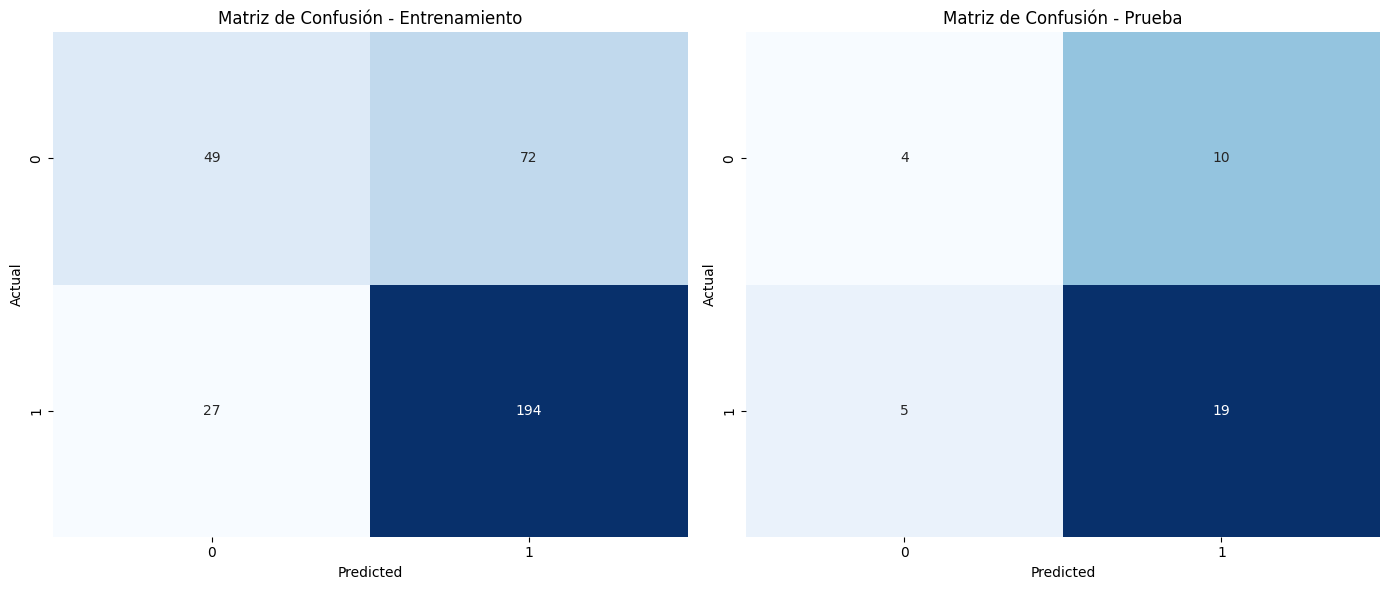

In [325]:
# Generar las matrices de confusión
cm_tv = confusion_matrix(ytv1, ytv1_pred_ensamble1)
cm_test = confusion_matrix(ytest1, ytest1_pred_ensamble1)

# Crear DataFrames de las matrices de confusión
cm_tv_df = pd.DataFrame(cm_tv, index=[0, 1], columns=[0, 1])
cm_test_df = pd.DataFrame(cm_test, index=[0, 1], columns=[0, 1])

# Crear el heatmap usando seaborn
plt.figure(figsize=(14, 6))

# Heatmap de la matriz de confusión de entrenamiento
plt.subplot(1, 2, 1)
sns.heatmap(cm_tv_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Heatmap de la matriz de confusión de prueba
plt.subplot(1, 2, 2)
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

#### 2.2.2 Bagging con Regresión Logística

In [326]:
# Definimos el modelo
start_time = time.time()
reg = LogisticRegression(solver='liblinear', class_weight= "balanced",
                         max_iter= 100, penalty = 'l2', tol = 0.0001, random_state=0)

# se ajusta el modelo
reg.fit(Xtv1, ytv1)
tiempo_fit_reg = time.time() - start_time

# generamos el ensamble usando bagging
start_time = time.time()
ensamble4 = BaggingClassifier(base_estimator=reg, n_estimators=200, random_state=42)

# Entrenamos el ensamble
ensamble4.fit(Xtv1, ytv1)
tiempo_fit_ensamble4 = time.time() - start_time

# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento

ytv_pred = cross_val_predict(reg, Xtv1, ytv1, cv=5)
recall_tv = recall_score(ytv1, ytv_pred, average='binary')
recall_tv_macro = recall_score(ytv1, ytv_pred, average='macro')
f1_tv = f1_score(ytv1, ytv_pred, average='binary')

ytv_pred_ensamble4 = ensamble4.predict(Xtv1)
recall_tv_ensamble4 = recall_score(ytv1, ytv_pred_ensamble4, average='binary')
recall_tv_macro_ensamble4 = recall_score(ytv1, ytv_pred_ensamble4, average='macro')
f1_tv_ensamble4 = f1_score(ytv1, ytv_pred_ensamble4, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'Regresión logística', 'Ensemble'],
    'Recall': [recall_test_dum, recall_tv,  recall_tv_ensamble4],
    'Recall Macro': [recall_test_macro_dum, recall_tv_macro, recall_tv_macro_ensamble4],
    'F1 Score': [f1_test_dum, f1_tv, f1_tv_ensamble4],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_reg, tiempo_fit_ensamble4]
}

# Crear un DataFrame para almacenar los resultados
cuadro1_df = pd.DataFrame(cuadro1,index=cuadro1["Modelo"])
cuadro1_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro1_df = cuadro1_df.sort_values(by='F1 Score', ascending=False)


# Evaluamos el rendimiento de los modelos con el conjunto de pruebas

ytest_pred = cross_val_predict(reg, Xtest1, ytest1, cv=5)
recall_test = recall_score(ytest1, ytest_pred, average='binary')
recall_test_macro = recall_score(ytest1, ytest_pred, average='macro')
f1_test = f1_score(ytest1, ytest_pred, average='binary')

ytest_pred_ensamble4 = ensamble4.predict(Xtest1)
recall_test_ensamble4 = recall_score(ytest1, ytest_pred_ensamble4, average='binary')
recall_test_macro_ensamble4 = recall_score(ytest1, ytest_pred_ensamble4, average='macro')
f1_test_ensamble4 = f1_score(ytest1, ytest_pred_ensamble4, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'Regresión logística', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test, recall_test_ensamble4],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro, recall_test_macro_ensamble4],
    'F1 Score': [f1_test_dum, f1_test, f1_test_ensamble4],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_reg, tiempo_fit_ensamble4]
}

# Crear un DataFrame para almacenar los resultados
cuadro2_df = pd.DataFrame(cuadro2,index=cuadro2["Modelo"])
cuadro2_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro2_df = cuadro2_df.sort_values(by='F1 Score', ascending=False)

# Aquí puedes especificar el axis=0 para columnas o axis=1 para filas
display_side_by_side([cuadro1_df, cuadro2_df], ['Conjunto de Entrenamiento', 'Conjunto de Pruebas'],
                     color='lightblue', axis=0)

,Recall,Recall Macro,F1 Score,Fit_Time
Dummy,0.000000,0.000000,0.774194,0.001853
Ensemble,0.733032,0.688830,0.760563,2.185195
Regresión logística,0.588235,0.554448,0.635697,0.015647
,Recall,Recall Macro,F1 Score,Fit_Time
Dummy,0.000000,0.000000,0.774194,0.001853
Regresión logística,0.666667,0.547619,0.666667,0.015647
Ensemble,0.666667,0.547619,0.666667,2.185195


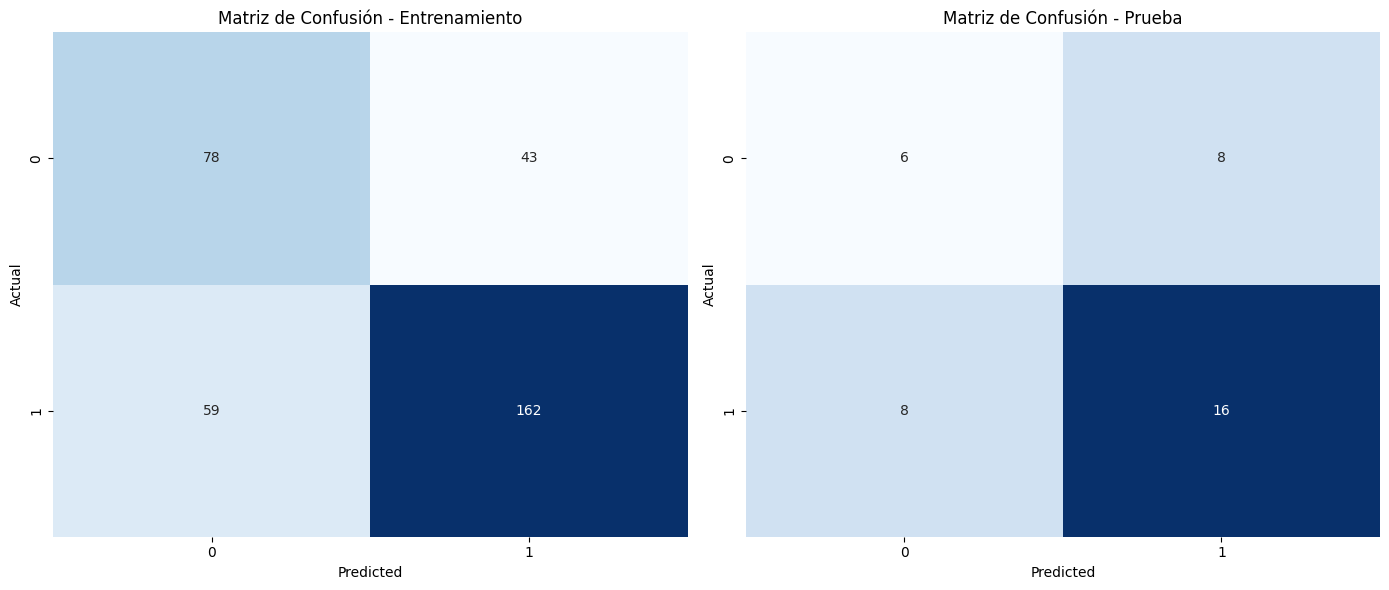

In [327]:
# Generar las matrices de confusión
cm_tv = confusion_matrix(ytv1, ytv_pred_ensamble4)
cm_test = confusion_matrix(ytest1, ytest_pred_ensamble4)

# Crear DataFrames de las matrices de confusión
cm_tv_df = pd.DataFrame(cm_tv, index=[0, 1], columns=[0, 1])
cm_test_df = pd.DataFrame(cm_test, index=[0, 1], columns=[0, 1])

# Crear el heatmap usando seaborn
plt.figure(figsize=(14, 6))

# Heatmap de la matriz de confusión de entrenamiento
plt.subplot(1, 2, 1)
sns.heatmap(cm_tv_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Heatmap de la matriz de confusión de prueba
plt.subplot(1, 2, 2)
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

#### 2.2.3 Bagging con red Neuronal

In [328]:
#Generamos la base con las características y la variable de salida
X2 = df_TCL.drop(columns=['Sintomas_ansiosos_encoded'])
Y2 = df_TCL['Sintomas_ansiosos_encoded']
Xtv2, Xtest2, ytv2, ytest2 = train_test_split(X2, Y2, train_size = 0.9, random_state = 0)

In [329]:
# Definimos el modelo
start_time = time.time()
red = MLPClassifier(solver="adam",  activation = 'logistic', alpha = 0.1, hidden_layer_sizes = (50,),
                    learning_rate_init = 0.01, max_iter = 500, random_state=42)

# se ajusta el modelo
red.fit(Xtv2, ytv2)
tiempo_fit_red = time.time() - start_time

# generamos el ensamble usando bagging
start_time = time.time()
ensamble6 = BaggingClassifier(base_estimator=red, n_estimators=200, random_state=42)

# Entrenamos el ensamble
ensamble6.fit(Xtv2, ytv2)
tiempo_fit_ensamble6 = time.time() - start_time

# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento

ytv_pred = cross_val_predict(red, Xtv2, ytv2, cv=5)
recall_tv = recall_score(ytv2, ytv_pred, average='binary')
recall_tv_macro = recall_score(ytv2, ytv_pred, average='macro')
f1_tv = f1_score(ytv2, ytv_pred, average='binary')

ytv_pred_ensamble6 = ensamble6.predict(Xtv2)
recall_tv_ensamble6 = recall_score(ytv2, ytv_pred_ensamble6, average='binary')
recall_tv_macro_ensamble6 = recall_score(ytv2, ytv_pred_ensamble6, average='macro')
f1_tv_ensamble6 = f1_score(ytv2, ytv_pred_ensamble6, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'red neuronal', 'Ensemble'],
    'Recall': [recall_test_dum, recall_tv,  recall_tv_ensamble6],
    'Recall Macro': [recall_test_macro_dum, recall_tv_macro, recall_tv_macro_ensamble6],
    'F1 Score': [f1_test_dum, f1_tv, f1_tv_ensamble6],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_red,tiempo_fit_ensamble6]
}

# Crear un DataFrame para almacenar los resultados
cuadro1_df = pd.DataFrame(cuadro1,index=cuadro1["Modelo"])
cuadro1_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro1_df = cuadro1_df.sort_values(by='F1 Score', ascending=False)


# Evaluamos el rendimiento de los modelos con el conjunto de pruebas

ytest_pred = cross_val_predict(red, Xtest2, ytest2, cv=5)
recall_test = recall_score(ytest2, ytest_pred, average='binary')
recall_test_macro = recall_score(ytest2, ytest_pred, average='macro')
f1_test = f1_score(ytest2, ytest_pred, average='binary')

ytest_pred_ensamble6 = ensamble6.predict(Xtest2)
recall_test_ensamble6 = recall_score(ytest2, ytest_pred_ensamble6, average='binary')
recall_test_macro_ensamble6 = recall_score(ytest2, ytest_pred_ensamble6, average='macro')
f1_test_ensamble6 = f1_score(ytest2, ytest_pred_ensamble6, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'red neuronal', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test, recall_test_ensamble6],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro, recall_test_macro_ensamble6],
    'F1 Score': [f1_test_dum, f1_test, f1_test_ensamble6],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_red,tiempo_fit_ensamble6]
}

# Crear un DataFrame para almacenar los resultados
cuadro2_df = pd.DataFrame(cuadro2,index=cuadro2["Modelo"])
cuadro2_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro2_df = cuadro2_df.sort_values(by='F1 Score', ascending=False)

# Aquí puedes especificar el axis=0 para columnas o axis=1 para filas
display_side_by_side([cuadro1_df, cuadro2_df], ['Conjunto de Entrenamiento', 'Conjunto de Pruebas'],
                     color='lightblue', axis=0)

,Recall,Recall Macro,F1 Score,Fit_Time
Ensemble,0.990950,0.987211,0.990950,189.121139
Dummy,0.000000,0.000000,0.774194,0.001853
red neuronal,0.719457,0.545679,0.697368,0.778499
,Recall,Recall Macro,F1 Score,Fit_Time
Dummy,0.000000,0.000000,0.774194,0.001853
Ensemble,0.666667,0.511905,0.653061,189.121139
red neuronal,0.583333,0.434524,0.583333,0.778499


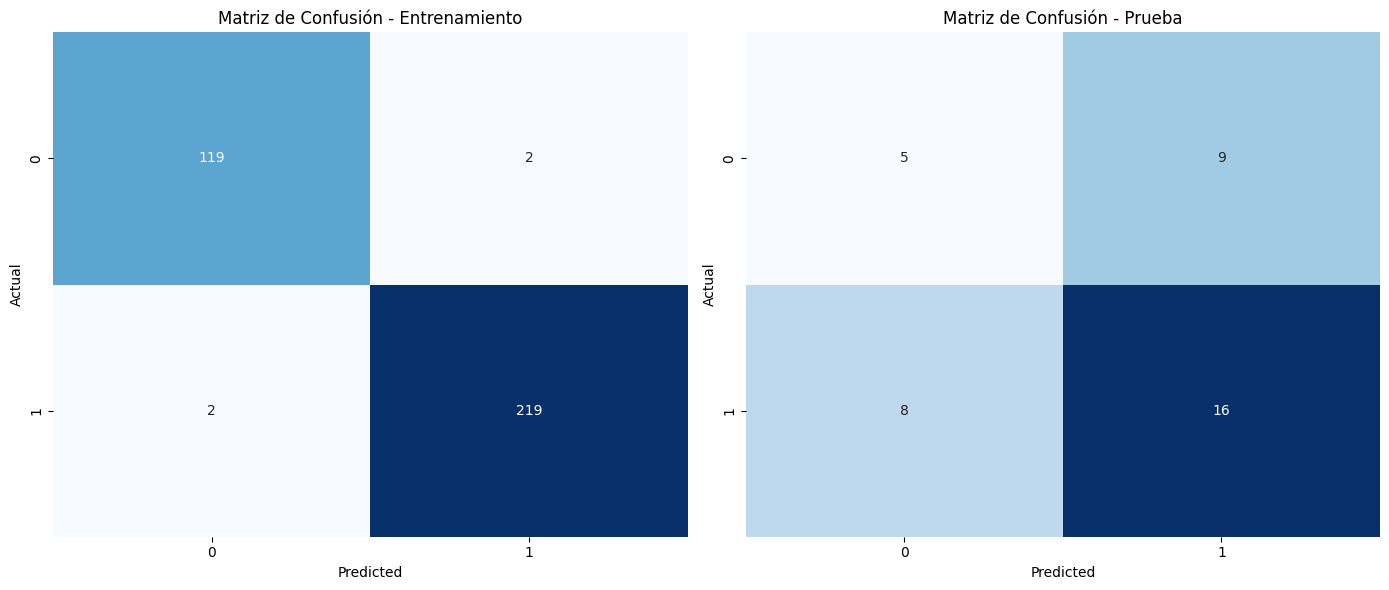

In [330]:
# Generar las matrices de confusión
cm_tv = confusion_matrix(ytv2, ytv_pred_ensamble6)
cm_test = confusion_matrix(ytest2, ytest_pred_ensamble6)

# Crear DataFrames de las matrices de confusión
cm_tv_df = pd.DataFrame(cm_tv, index=[0, 1], columns=[0, 1])
cm_test_df = pd.DataFrame(cm_test, index=[0, 1], columns=[0, 1])

# Crear el heatmap usando seaborn
plt.figure(figsize=(14, 6))

# Heatmap de la matriz de confusión de entrenamiento
plt.subplot(1, 2, 1)
sns.heatmap(cm_tv_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Heatmap de la matriz de confusión de prueba
plt.subplot(1, 2, 2)
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

### **2.3 Refinamiento de hiperparámetros de los mejores modelos semana 5**

#### 2.3.1 Stacking con Regresión logística y SVM

In [331]:
# Definir los modelos
start_time = time.time()
ensamble1 = LogisticRegression( random_state=0, solver="liblinear")

param_grid = {
    'class_weight': [None, 'balanced'],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],
    'max_iter': [30, 50, 100, 200, 300]
}

grid_search = GridSearchCV(estimator=ensamble1, param_grid=param_grid,
                           cv=5, scoring='recall', n_jobs=-1, verbose=1)

grid_search.fit(stacked_tv, ytv1)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor F1 Score: {best_score}")


# Medir el tiempo de ajuste del ensamble con los mejores hiperparametros
ensamble1_best = LogisticRegression(**best_params)
ensamble1_best.fit(stacked_tv, ytv1)
tiempo_fit_ensamble1_best = time.time() - start_time

# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento

ytv1_pred_dum = cross_val_predict(dummy_clf, Xtv1, ytv1, cv=5)
recall_tv_dum = 0 # No se calcula ya que recall evalua la tasa de verdaderos positivos y
                    #nuestro Dummy genera un 100% de positivos.
recall_tv_macro_dum = 0
f1_tv_dum = f1_score(ytv1, ytv1_pred_dum, average='binary')


ytv1_pred_reg = cross_val_predict(reg, Xtv1, ytv1, cv=5)
recall_tv_reg = recall_score(ytv1, ytv1_pred_reg, average='binary')
recall_tv_macro_reg = recall_score(ytv1, ytv1_pred_reg, average='macro')
f1_tv_reg = f1_score(ytv1, ytv1_pred_reg, average='binary')


ytv1_pred_svm = cross_val_predict(svm, Xtv1, ytv1, cv=5)
recall_tv_svm = recall_score(ytv1, ytv1_pred_svm, average='binary')
recall_tv_macro_svm = recall_score(ytv1, ytv1_pred_svm, average='macro')
f1_tv_svm = f1_score(ytv1, ytv1_pred_svm, average='binary')


ytv1_pred_ensamble1_best = ensamble1_best.predict(stacked_tv)
recall_tv_ensamble1_best = recall_score(ytv1, ytv1_pred_ensamble1_best, average='binary')
recall_tv_macro_ensamble1_best = recall_score(ytv1, ytv1_pred_ensamble1_best, average='macro')
f1_tv_ensamble1_best = f1_score(ytv1, ytv1_pred_ensamble1_best, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'Regression Logística', 'SVM', 'Ensemble'],
    'Recall': [recall_tv_dum, recall_tv_reg, recall_tv_svm, recall_tv_ensamble1_best],
    'Recall Macro': [recall_tv_macro_dum, recall_tv_macro_reg, recall_tv_macro_svm, recall_tv_macro_ensamble1_best],
    'F1 Score': [f1_tv_dum, f1_tv_reg, f1_tv_svm, f1_tv_ensamble1_best],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_reg, tiempo_fit_svm, tiempo_fit_ensamble1_best]
}

# Crear un DataFrame para almacenar los resultados
cuadro1_df = pd.DataFrame(cuadro1,index=cuadro1["Modelo"])
cuadro1_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro1_df = cuadro1_df.sort_values(by='F1 Score', ascending=False)


# Evaluamos el rendimiento de los modelos con el conjunto de pruebas
ytest1_pred_dum = cross_val_predict(dummy_clf, Xtest1, ytest1, cv=5)
recall_test_dum = 0
recall_test_macro_dum = 0
f1_test_dum = f1_score(ytest1, ytest1_pred_dum, average='binary')


ytest1_pred_reg = cross_val_predict(reg, Xtest1, ytest1, cv=5)
recall_test_reg = recall_score(ytest1, ytest1_pred_reg, average='binary')
recall_test_macro_reg = recall_score(ytest1, ytest1_pred_reg, average='macro')
f1_test_reg = f1_score(ytest1, ytest1_pred_reg, average='binary')


ytest1_pred_svm = cross_val_predict(svm, Xtest1, ytest1, cv=5)
recall_test_svm = recall_score(ytest1, ytest1_pred_svm, average='binary')
recall_test_macro_svm = recall_score(ytest1, ytest1_pred_svm, average='macro')
f1_test_svm = f1_score(ytest1, ytest1_pred_svm, average='binary')


ytest1_pred_ensamble1_best = ensamble1_best.predict(stacked_test)
recall_test_ensamble1_best = recall_score(ytest1, ytest1_pred_ensamble1_best, average='binary')
recall_test_macro_ensamble1_best = recall_score(ytest1, ytest1_pred_ensamble1_best, average='macro')
f1_test_ensamble1_best = f1_score(ytest1, ytest1_pred_ensamble1_best, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'Regression Logística', 'SVM', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test_reg, recall_test_svm, recall_test_ensamble1_best],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro_reg, recall_test_macro_svm, recall_test_macro_ensamble1_best],
    'F1 Score': [f1_test_dum, f1_test_reg, f1_test_svm, f1_test_ensamble1_best],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_reg, tiempo_fit_svm, tiempo_fit_ensamble1_best]
}

cuadro2_df = pd.DataFrame(cuadro2)

# Crear un DataFrame para almacenar los resultados
cuadro2_df = pd.DataFrame(cuadro2,index=cuadro2["Modelo"])
cuadro2_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro2_df = cuadro2_df.sort_values(by='F1 Score', ascending=False)

# Aquí puedes especificar el axis=0 para columnas o axis=1 para filas
display_side_by_side([cuadro1_df, cuadro2_df], ['Conjunto de Entrenamiento', 'Conjunto de Pruebas'],
                     color='lightblue', axis=0)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Mejores hiperparámetros: {'class_weight': None, 'max_iter': 30, 'penalty': 'l2', 'tol': 0.0001}
Mejor F1 Score: 0.914040404040404


,Recall,Recall Macro,F1 Score,Fit_Time
Ensemble,0.877828,0.641393,0.796715,4.357153
Dummy,0.000000,0.000000,0.785080,0.001853
SVM,0.610860,0.623612,0.675000,0.121132
Regression Logística,0.588235,0.554448,0.635697,0.015647
,Recall,Recall Macro,F1 Score,Fit_Time
Dummy,0.000000,0.000000,0.774194,0.001853
Ensemble,0.791667,0.538690,0.716981,4.357153
Regression Logística,0.666667,0.547619,0.666667,0.015647
SVM,0.666667,0.511905,0.653061,0.121132


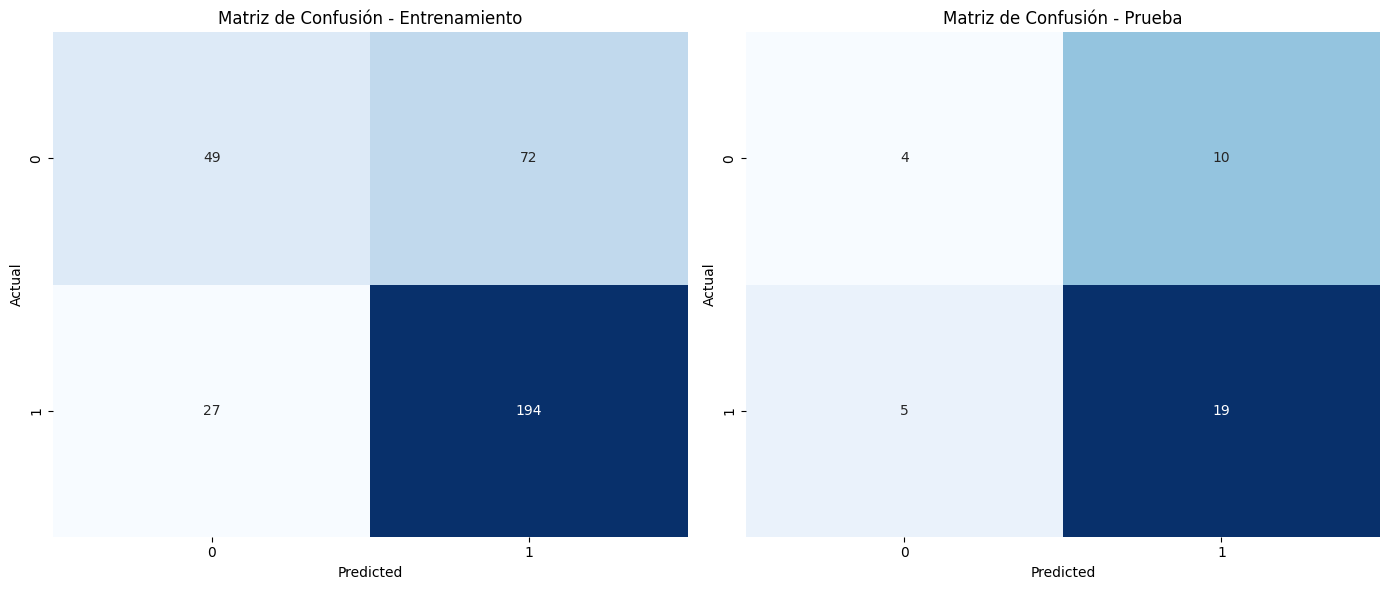

In [332]:
# Generar las matrices de confusión
cm_tv = confusion_matrix(ytv1, ytv1_pred_ensamble1_best)
cm_test = confusion_matrix(ytest1, ytest1_pred_ensamble1_best)

# Crear DataFrames de las matrices de confusión
cm_tv_df = pd.DataFrame(cm_tv, index=[0, 1], columns=[0, 1])
cm_test_df = pd.DataFrame(cm_test, index=[0, 1], columns=[0, 1])

# Crear el heatmap usando seaborn
plt.figure(figsize=(14, 6))

# Heatmap de la matriz de confusión de entrenamiento
plt.subplot(1, 2, 1)
sns.heatmap(cm_tv_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Heatmap de la matriz de confusión de prueba
plt.subplot(1, 2, 2)
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

#### 2.3.2 Bagging con Regresión Logística

In [333]:
# Definimos el modelo
start_time = time.time()
reg = LogisticRegression(solver='liblinear', class_weight= "balanced",
                         max_iter= 100, penalty = 'l2', tol = 0.0001, random_state=0)

# se ajusta el modelo
reg.fit(Xtv1, ytv1)
tiempo_fit_reg = time.time() - start_time

# generamos el ensamble usando bagging
start_time = time.time()
ensamble4 = BaggingClassifier(base_estimator=reg, n_estimators=200, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

grid_search = GridSearchCV(estimator=ensamble4, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=1)

grid_search.fit(Xtv1, ytv1)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor Recall Score: {best_score}")

# Entrenamos el ensamble

best_bagging_params = {key: value for key, value in best_params.items() if 'base_estimator__' not in key}

ensamble4_best = BaggingClassifier(base_estimator=reg, **best_bagging_params, random_state=0)

ensamble4_best.fit(Xtv1, ytv1)

tiempo_fit_ensamble4_best = time.time() - start_time

# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento

ytv_pred = cross_val_predict(reg, Xtv1, ytv1, cv=5)
recall_tv = recall_score(ytv1, ytv_pred, average='binary')
recall_tv_macro = recall_score(ytv1, ytv_pred, average='macro')
f1_tv = f1_score(ytv1, ytv_pred, average='binary')

ytv_pred_ensamble4_best = ensamble4_best.predict(Xtv1)
recall_tv_ensamble4_best = recall_score(ytv1, ytv_pred_ensamble4_best, average='binary')
recall_tv_macro_ensamble4_best = recall_score(ytv1, ytv_pred_ensamble4_best, average='macro')
f1_tv_ensamble4_best = f1_score(ytv1, ytv_pred_ensamble4_best, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'Regresión logística', 'Ensemble'],
    'Recall': [recall_test_dum, recall_tv,  recall_tv_ensamble4_best],
    'Recall Macro': [recall_test_macro_dum, recall_tv_macro, recall_tv_macro_ensamble4_best],
    'F1 Score': [f1_test_dum, f1_tv, f1_tv_ensamble4_best],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_reg, tiempo_fit_ensamble4_best]
}

# Crear un DataFrame para almacenar los resultados
cuadro1_df = pd.DataFrame(cuadro1,index=cuadro1["Modelo"])
cuadro1_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro1_df = cuadro1_df.sort_values(by='F1 Score', ascending=False)


# Evaluamos el rendimiento de los modelos con el conjunto de pruebas

ytest_pred = cross_val_predict(reg, Xtest1, ytest1, cv=5)
recall_test = recall_score(ytest1, ytest_pred, average='binary')
recall_test_macro = recall_score(ytest1, ytest_pred, average='macro')
f1_test = f1_score(ytest1, ytest_pred, average='binary')

ytest_pred_ensamble4_best = ensamble4_best.predict(Xtest1)
recall_test_ensamble4_best = recall_score(ytest1, ytest_pred_ensamble4_best, average='binary')
recall_test_macro_ensamble4_best = recall_score(ytest1, ytest_pred_ensamble4_best, average='macro')
f1_test_ensamble4_best = f1_score(ytest1, ytest_pred_ensamble4_best, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'Regresión logística', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test, recall_test_ensamble4_best],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro, recall_test_macro_ensamble4_best],
    'F1 Score': [f1_test_dum, f1_test, f1_test_ensamble4_best],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_reg, tiempo_fit_ensamble4_best]
}

# Crear un DataFrame para almacenar los resultados
cuadro2_df = pd.DataFrame(cuadro2,index=cuadro2["Modelo"])
cuadro2_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro2_df = cuadro2_df.sort_values(by='F1 Score', ascending=False)

# Aquí puedes especificar el axis=0 para columnas o axis=1 para filas
display_side_by_side([cuadro1_df, cuadro2_df], ['Conjunto de Entrenamiento', 'Conjunto de Pruebas'],
                     color='lightblue', axis=0)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiperparámetros: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 200}
Mejor Recall Score: 0.678989898989899


,Recall,Recall Macro,F1 Score,Fit_Time
Dummy,0.000000,0.000000,0.774194,0.001853
Ensemble,0.742081,0.668561,0.755760,301.058674
Regresión logística,0.588235,0.554448,0.635697,0.010804
,Recall,Recall Macro,F1 Score,Fit_Time
Dummy,0.000000,0.000000,0.774194,0.001853
Regresión logística,0.666667,0.547619,0.666667,0.010804
Ensemble,0.666667,0.547619,0.666667,301.058674


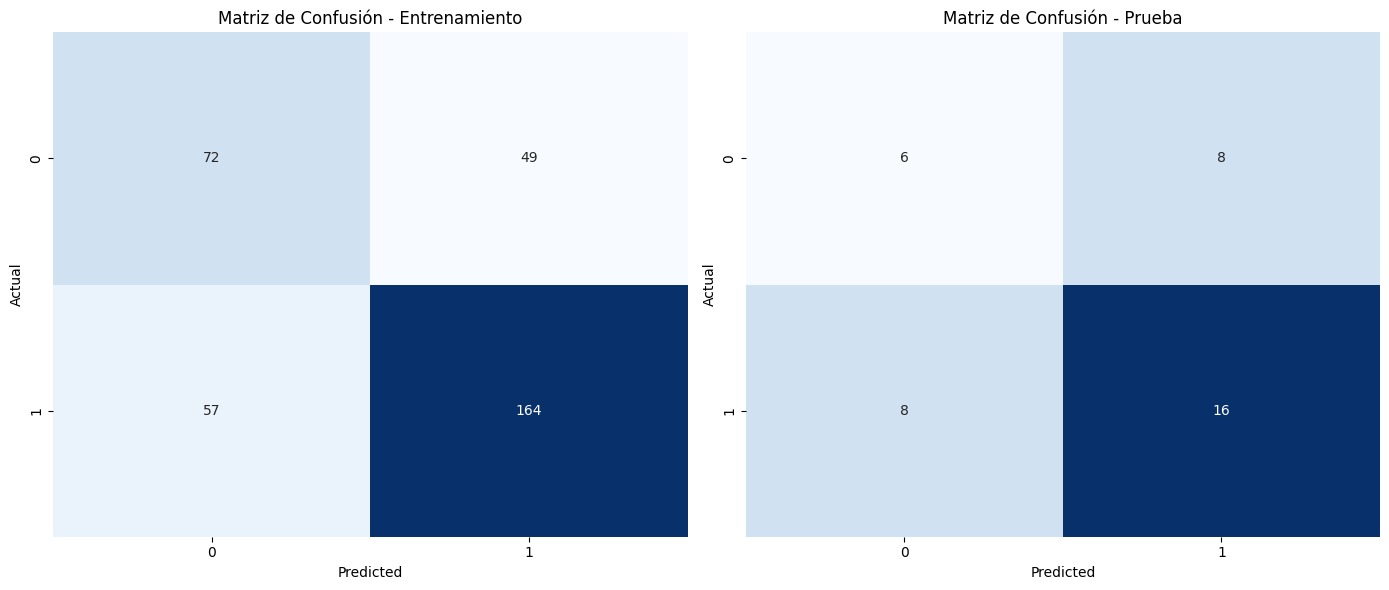

In [334]:
# Generar las matrices de confusión
cm_tv = confusion_matrix(ytv1, ytv_pred_ensamble4_best)
cm_test = confusion_matrix(ytest1, ytest_pred_ensamble4_best)

# Crear DataFrames de las matrices de confusión
cm_tv_df = pd.DataFrame(cm_tv, index=[0, 1], columns=[0, 1])
cm_test_df = pd.DataFrame(cm_test, index=[0, 1], columns=[0, 1])

# Crear el heatmap usando seaborn
plt.figure(figsize=(14, 6))

# Heatmap de la matriz de confusión de entrenamiento
plt.subplot(1, 2, 1)
sns.heatmap(cm_tv_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Heatmap de la matriz de confusión de prueba
plt.subplot(1, 2, 2)
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

#### 2.3.3 Bagging con red Neuronal

In [ ]:
# Definimos el modelo
start_time = time.time()
red = MLPClassifier(solver="adam",  activation = 'logistic', alpha = 0.1, hidden_layer_sizes = (50,),
                    learning_rate_init = 0.01, max_iter = 500, random_state=42)

# se ajusta el modelo
red.fit(Xtv2, ytv2)
tiempo_fit_red = time.time() - start_time

# generamos el ensamble usando bagging
start_time = time.time()
ensamble6 = BaggingClassifier(base_estimator=red, n_estimators=200, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}


grid_search = GridSearchCV(estimator=ensamble6, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=1)

grid_search.fit(Xtv2, ytv2)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor Recall Score: {best_score}")

# Entrenamos el ensamble

best_bagging_params = {key: value for key, value in best_params.items() if 'base_estimator__' not in key}

ensamble6_best = BaggingClassifier(base_estimator=red, **best_bagging_params, random_state=0)

ensamble6_best.fit(Xtv2, ytv2)

tiempo_fit_ensamble6_best = time.time() - start_time


# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento

ytv_pred = cross_val_predict(red, Xtv2, ytv2, cv=5)
recall_tv = recall_score(ytv2, ytv_pred, average='binary')
recall_tv_macro = recall_score(ytv2, ytv_pred, average='macro')
f1_tv = f1_score(ytv2, ytv_pred, average='binary')

ytv_pred_ensamble6_best = ensamble6_best.predict(Xtv2)
recall_tv_ensamble6_best = recall_score(ytv2, ytv_pred_ensamble6_best, average='binary')
recall_tv_macro_ensamble6_best = recall_score(ytv2, ytv_pred_ensamble6_best, average='macro')
f1_tv_ensamble6_best = f1_score(ytv2, ytv_pred_ensamble6_best, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'red neuronal', 'Ensemble'],
    'Recall': [recall_test_dum, recall_tv,  recall_tv_ensamble6_best],
    'Recall Macro': [recall_test_macro_dum, recall_tv_macro, recall_tv_macro_ensamble6_best],
    'F1 Score': [f1_test_dum, f1_tv, f1_tv_ensamble6_best],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_red,tiempo_fit_ensamble6_best]
}

# Crear un DataFrame para almacenar los resultados
cuadro1_df = pd.DataFrame(cuadro1,index=cuadro1["Modelo"])
cuadro1_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro1_df = cuadro1_df.sort_values(by='F1 Score', ascending=False)


# Evaluamos el rendimiento de los modelos con el conjunto de pruebas

ytest_pred = cross_val_predict(red, Xtest2, ytest2, cv=5)
recall_test = recall_score(ytest2, ytest_pred, average='binary')
recall_test_macro = recall_score(ytest2, ytest_pred, average='macro')
f1_test = f1_score(ytest2, ytest_pred, average='binary')

ytest_pred_ensamble6_best = ensamble6_best.predict(Xtest2)
recall_test_ensamble6_best = recall_score(ytest2, ytest_pred_ensamble6_best, average='binary')
recall_test_macro_ensamble6_best = recall_score(ytest2, ytest_pred_ensamble6_best, average='macro')
f1_test_ensamble6_best = f1_score(ytest2, ytest_pred_ensamble6_best, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'red neuronal', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test, recall_test_ensamble6_best],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro, recall_test_macro_ensamble6_best],
    'F1 Score': [f1_test_dum, f1_test, f1_test_ensamble6_best],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_red,tiempo_fit_ensamble6_best]
}

# Crear un DataFrame para almacenar los resultados
cuadro2_df = pd.DataFrame(cuadro2,index=cuadro2["Modelo"])
cuadro2_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro2_df = cuadro2_df.sort_values(by='F1 Score', ascending=False)

# Aquí puedes especificar el axis=0 para columnas o axis=1 para filas
display_side_by_side([cuadro1_df, cuadro2_df], ['Conjunto de Entrenamiento', 'Conjunto de Pruebas'],
                     color='lightblue', axis=0)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
# Generar las matrices de confusión
cm_tv = confusion_matrix(ytv2, ytv_pred_ensamble6_best)
cm_test = confusion_matrix(ytest2, ytest_pred_ensamble6_best)

# Crear DataFrames de las matrices de confusión
cm_tv_df = pd.DataFrame(cm_tv, index=[0, 1], columns=[0, 1])
cm_test_df = pd.DataFrame(cm_test, index=[0, 1], columns=[0, 1])

# Crear el heatmap usando seaborn
plt.figure(figsize=(14, 6))

# Heatmap de la matriz de confusión de entrenamiento
plt.subplot(1, 2, 1)
sns.heatmap(cm_tv_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Heatmap de la matriz de confusión de prueba
plt.subplot(1, 2, 2)
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

### **2.4 Refinamiento de hiperparámetros de los mejores modelos semana 5 con datos menos desbalanceados**

Como ya explicamos, usaremos solo el submuestreo que fue la técnica que arrojó Los mejores resultados en la semana 4. También, al tener una base de datos tan pequeña, eliminar elementos de la clase mayoritaria puede resultar muy costoso, por lo que utilizaremos un desbalance del 60-40 (que además corroboramos que era la combinación que daba mejores resultados). Así, para el parámetro sampling_strategy utilizaremos la fórmula 40/60 que es apróximadamente 0.6667.


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(sampling_strategy=0.6667, random_state=0) #balanceando al 40-60

Xtv1_res, Ytv1_res = undersampler.fit_resample(Xtv1, ytv1)

In [ ]:
# Creamos un modelo
start_time = time.time()
dummy_clf = DummyClassifier(strategy='most_frequent', random_state= 0)

# Se ajusta el modelo a los datos de entrenamiento
dummy_clf.fit(Xtv1_res, Ytv1_res)
tiempo_fit_dummy_res = time.time() - start_time

preds_dum_res_tv = dummy_clf.predict_proba(Xtv1_res)

#### 2.4.1 Stacking con Regresión logística y SVM

In [ ]:
# Definimos el modelo
start_time_fit = time.time()
reg_res = LogisticRegression(solver='liblinear', class_weight= "balanced",
                         max_iter= 100, penalty = 'l2', tol = 0.0001, random_state=0)

# Se ajusta el modelo
reg_res.fit(Xtv1_res, Ytv1_res)
end_time_fit = time.time()
tiempo_fit_reg_res = end_time_fit - start_time_fit

preds_reg_res_tv = reg_res.predict_proba(Xtv1_res)[:, 1]
preds_reg_res_test = reg_res.predict_proba(Xtest1)[:, 1]

In [ ]:
# Definimos el modelo
start_time_fit = time.time()
svm_res = SVC(class_weight='balanced', probability=True, C = 0.01, gamma = 0.001, kernel = 'linear', random_state=0)

# Se ajusta el modelo
svm_res.fit(Xtv1_res, Ytv1_res)
end_time_fit = time.time()
tiempo_fit_svm_res = end_time_fit - start_time_fit

preds_svm_res_tv = svm_res.predict_proba(Xtv1_res)[:, 1]
preds_svm_res_test = svm_res.predict_proba(Xtest1)[:, 1]


In [ ]:
# Creamos el conjunto de datos para el ensamble
stacked_res_tv = np.column_stack((preds_reg_res_tv, preds_svm_res_tv))

In [ ]:
# Definir los modelos
start_time = time.time()
ensamble1 = LogisticRegression( random_state=0, solver="liblinear")

param_grid = {
    'class_weight': [None, 'balanced'],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],
    'max_iter': [30, 50, 100, 200, 300]
}

grid_search = GridSearchCV(estimator=ensamble1, param_grid=param_grid,
                           cv=5, scoring='recall', n_jobs=-1, verbose=1)

grid_search.fit(stacked_res_tv, Ytv1_res)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor F1 Score: {best_score}")


# Medir el tiempo de ajuste del ensamble con los mejores hiperparametros
ensamble1_res_best = LogisticRegression(**best_params)
ensamble1_res_best.fit(stacked_res_tv, Ytv1_res)
tiempo_fit_ensamble1_res_best = time.time() - start_time

# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento

ytv1_pred_dum = cross_val_predict(dummy_clf, Xtv1_res, Ytv1_res, cv=5)
recall_tv_dum_res = 0 # No se calcula ya que recall evalua la tasa de verdaderos positivos y
                    #nuestro Dummy genera un 100% de positivos.
recall_tv_macro_dum_res = 0
f1_tv_dum_res = f1_score(Ytv1_res, ytv1_pred_dum, average='binary')


ytv1_pred_reg = cross_val_predict(reg_res, Xtv1_res, Ytv1_res, cv=5)
recall_tv_reg_res = recall_score(Ytv1_res, ytv1_pred_reg, average='binary')
recall_tv_macro_reg_res = recall_score(Ytv1_res, ytv1_pred_reg, average='macro')
f1_tv_reg_res = f1_score(Ytv1_res, ytv1_pred_reg, average='binary')


ytv1_pred_svm = cross_val_predict(svm_res, Xtv1_res, Ytv1_res, cv=5)
recall_tv_svm_res = recall_score(Ytv1_res, ytv1_pred_svm, average='binary')
recall_tv_macro_svm_res = recall_score(Ytv1_res, ytv1_pred_svm, average='macro')
f1_tv_svm_res = f1_score(Ytv1_res, ytv1_pred_svm, average='binary')


ytv1_pred_ensamble1_best = ensamble1_res_best.predict(stacked_res_tv)
recall_tv_ensamble1_res_best = recall_score(Ytv1_res, ytv1_pred_ensamble1_best, average='binary')
recall_tv_macro_ensamble1_res_best = recall_score(Ytv1_res, ytv1_pred_ensamble1_best, average='macro')
f1_tv_ensamble1_res_best = f1_score(Ytv1_res, ytv1_pred_ensamble1_best, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'Regression Logística', 'SVM', 'Ensemble'],
    'Recall': [recall_tv_dum_res, recall_tv_reg_res, recall_tv_svm_res, recall_tv_ensamble1_res_best],
    'Recall Macro': [recall_tv_macro_dum_res, recall_tv_macro_reg_res, recall_tv_macro_svm_res, recall_tv_macro_ensamble1_res_best],
    'F1 Score': [f1_tv_dum_res, f1_tv_reg_res, f1_tv_svm_res, f1_tv_ensamble1_res_best],
    'Fit_Time': [tiempo_fit_dummy_res, tiempo_fit_reg_res, tiempo_fit_svm_res, tiempo_fit_ensamble1_res_best]
}

# Crear un DataFrame para almacenar los resultados
cuadro1_df = pd.DataFrame(cuadro1,index=cuadro1["Modelo"])
cuadro1_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro1_df = cuadro1_df.sort_values(by='F1 Score', ascending=False)


# Evaluamos el rendimiento de los modelos con el conjunto de pruebas
ytest1_pred_dum = cross_val_predict(dummy_clf, Xtest1, ytest1, cv=5)
recall_test_dum = 0
recall_test_macro_dum = 0
f1_test_dum = f1_score(ytest1, ytest1_pred_dum, average='binary')


ytest1_pred_reg = cross_val_predict(reg_res, Xtest1, ytest1, cv=5)
recall_test_reg = recall_score(ytest1, ytest1_pred_reg, average='binary')
recall_test_macro_reg = recall_score(ytest1, ytest1_pred_reg, average='macro')
f1_test_reg = f1_score(ytest1, ytest1_pred_reg, average='binary')


ytest1_pred_svm = cross_val_predict(svm_res, Xtest1, ytest1, cv=5)
recall_test_svm = recall_score(ytest1, ytest1_pred_svm, average='binary')
recall_test_macro_svm = recall_score(ytest1, ytest1_pred_svm, average='macro')
f1_test_svm = f1_score(ytest1, ytest1_pred_svm, average='binary')


ytest1_pred_ensamble1_best = ensamble1_res_best.predict(stacked_test)
recall_test_ensamble1_best = recall_score(ytest1, ytest1_pred_ensamble1_best, average='binary')
recall_test_macro_ensamble1_best = recall_score(ytest1, ytest1_pred_ensamble1_best, average='macro')
f1_test_ensamble1_best = f1_score(ytest1, ytest1_pred_ensamble1_best, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'Regression Logística', 'SVM', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test_reg, recall_test_svm, recall_test_ensamble1_best],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro_reg, recall_test_macro_svm, recall_test_macro_ensamble1_best],
    'F1 Score': [f1_test_dum, f1_test_reg, f1_test_svm, f1_test_ensamble1_best],
    'Fit_Time': [tiempo_fit_dummy_res, tiempo_fit_reg_res, tiempo_fit_svm_res, tiempo_fit_ensamble1_res_best]
}

cuadro2_df = pd.DataFrame(cuadro2)

# Crear un DataFrame para almacenar los resultados
cuadro2_df = pd.DataFrame(cuadro2,index=cuadro2["Modelo"])
cuadro2_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro2_df = cuadro2_df.sort_values(by='F1 Score', ascending=False)

# Aquí puedes especificar el axis=0 para columnas o axis=1 para filas
display_side_by_side([cuadro1_df, cuadro2_df], ['Conjunto de Entrenamiento', 'Conjunto de Pruebas'],
                     color='lightblue', axis=0)

In [ ]:
# Generar las matrices de confusión
cm_tv = confusion_matrix(Ytv1_res, ytv1_pred_ensamble1_best)
cm_test = confusion_matrix(ytest1, ytest1_pred_ensamble1_best)

# Crear DataFrames de las matrices de confusión
cm_tv_df = pd.DataFrame(cm_tv, index=[0, 1], columns=[0, 1])
cm_test_df = pd.DataFrame(cm_test, index=[0, 1], columns=[0, 1])

# Crear el heatmap usando seaborn
plt.figure(figsize=(14, 6))

# Heatmap de la matriz de confusión de entrenamiento
plt.subplot(1, 2, 1)
sns.heatmap(cm_tv_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Heatmap de la matriz de confusión de prueba
plt.subplot(1, 2, 2)
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

#### 2.4.2 Bagging con Regresión Logística

In [ ]:
# Definimos el modelo
start_time = time.time()
reg_res = LogisticRegression(solver='liblinear', class_weight= "balanced",
                         max_iter= 100, penalty = 'l2', tol = 0.0001, random_state=0)

# se ajusta el modelo
reg_res.fit(Xtv1_res, Ytv1_res)
tiempo_fit_reg_res = time.time() - start_time

# generamos el ensamble usando bagging
start_time = time.time()
ensamble4_res = BaggingClassifier(base_estimator=reg_res, n_estimators=200, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

grid_search = GridSearchCV(estimator=ensamble4_res, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=1)

grid_search.fit(Xtv1_res, Ytv1_res)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor Recall Score: {best_score}")

# Entrenamos el ensamble

best_bagging_params = {key: value for key, value in best_params.items() if 'base_estimator__' not in key}

ensamble4_res_best = BaggingClassifier(base_estimator=reg_res, **best_bagging_params, random_state=0)

ensamble4_res_best.fit(Xtv1_res, Ytv1_res)

tiempo_fit_ensamble4_res_best = time.time() - start_time

# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento

ytv_pred = cross_val_predict(reg_res, Xtv1_res, Ytv1_res, cv=5)
recall_tv_reg_res = recall_score(Ytv1_res, ytv_pred, average='binary')
recall_tv_macro_reg_res = recall_score(Ytv1_res, ytv_pred, average='macro')
f1_tv_reg_res = f1_score(Ytv1_res, ytv_pred, average='binary')

ytv_pred_ensamble4_best = ensamble4_res_best.predict(Xtv1_res)
recall_tv_ensamble4_res_best = recall_score(Ytv1_res, ytv_pred_ensamble4_best, average='binary')
recall_tv_macro_ensamble4_res_best = recall_score(Ytv1_res, ytv_pred_ensamble4_best, average='macro')
f1_tv_ensamble4_res_best = f1_score(Ytv1_res, ytv_pred_ensamble4_best, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'Regresión logística', 'Ensemble'],
    'Recall': [recall_tv_dum_res, recall_tv_reg_res,  recall_tv_ensamble4_res_best],
    'Recall Macro': [recall_tv_macro_dum_res, recall_tv_macro_reg_res, recall_tv_macro_ensamble4_res_best],
    'F1 Score': [f1_tv_dum_res, f1_tv_reg_res, f1_tv_ensamble4_res_best],
    'Fit_Time': [tiempo_fit_dummy_res, tiempo_fit_reg_res, tiempo_fit_ensamble4_res_best]
}

# Crear un DataFrame para almacenar los resultados
cuadro1_df = pd.DataFrame(cuadro1,index=cuadro1["Modelo"])
cuadro1_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro1_df = cuadro1_df.sort_values(by='F1 Score', ascending=False)


# Evaluamos el rendimiento de los modelos con el conjunto de pruebas

ytest_pred = cross_val_predict(reg, Xtest1, ytest1, cv=5)
recall_test_reg_res = recall_score(ytest1, ytest_pred, average='binary')
recall_test_macro_reg_res = recall_score(ytest1, ytest_pred, average='macro')
f1_test_reg_res = f1_score(ytest1, ytest_pred, average='binary')

ytest_pred_ensamble4_best = ensamble4_res_best.predict(Xtest1)
recall_test_ensamble4_res_best = recall_score(ytest1, ytest_pred_ensamble4_best, average='binary')
recall_test_macro_ensamble4_res_best = recall_score(ytest1, ytest_pred_ensamble4_best, average='macro')
f1_test_ensamble4_res_best = f1_score(ytest1, ytest_pred_ensamble4_best, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'Regresión logística', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test_reg_res, recall_test_ensamble4_res_best],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro_reg_res, recall_test_macro_ensamble4_res_best],
    'F1 Score': [f1_test_dum, f1_test_reg_res, f1_test_ensamble4_res_best],
    'Fit_Time': [tiempo_fit_dummy_res, tiempo_fit_reg_res, tiempo_fit_ensamble4_res_best]
}

# Crear un DataFrame para almacenar los resultados
cuadro2_df = pd.DataFrame(cuadro2,index=cuadro2["Modelo"])
cuadro2_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro2_df = cuadro2_df.sort_values(by='F1 Score', ascending=False)

# Aquí puedes especificar el axis=0 para columnas o axis=1 para filas
display_side_by_side([cuadro1_df, cuadro2_df], ['Conjunto de Entrenamiento', 'Conjunto de Pruebas'],
                     color='lightblue', axis=0)

In [ ]:
# Generar las matrices de confusión
cm_tv = confusion_matrix(Ytv1_res, ytv_pred_ensamble4_best)
cm_test = confusion_matrix(ytest1, ytest_pred_ensamble4_best)

# Crear DataFrames de las matrices de confusión
cm_tv_df = pd.DataFrame(cm_tv, index=[0, 1], columns=[0, 1])
cm_test_df = pd.DataFrame(cm_test, index=[0, 1], columns=[0, 1])

# Crear el heatmap usando seaborn
plt.figure(figsize=(14, 6))

# Heatmap de la matriz de confusión de entrenamiento
plt.subplot(1, 2, 1)
sns.heatmap(cm_tv_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Heatmap de la matriz de confusión de prueba
plt.subplot(1, 2, 2)
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

#### 2.4.3 Bagging con Red Neuronal

In [ ]:
Xtv2_res, Ytv2_res = undersampler.fit_resample(Xtv2, ytv2)

# Definimos el modelo
start_time = time.time()
red_res = MLPClassifier(solver="adam",  activation = 'logistic', alpha = 0.1, hidden_layer_sizes = (50,),
                    learning_rate_init = 0.01, max_iter = 500, random_state=42)

# se ajusta el modelo
red_res.fit(Xtv2_res, Ytv2_res)
tiempo_fit_red_res = time.time() - start_time

# generamos el ensamble usando bagging
start_time = time.time()
ensamble6_res = BaggingClassifier(base_estimator=red_res, n_estimators=200, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}


grid_search = GridSearchCV(estimator=ensamble6_res, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=1)

grid_search.fit(Xtv2_res, Ytv2_res)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor Recall Score: {best_score}")

# Entrenamos el ensamble

best_bagging_params = {key: value for key, value in best_params.items() if 'base_estimator__' not in key}

ensamble6_res_best = BaggingClassifier(base_estimator=red_res, **best_bagging_params, random_state=0)

ensamble6_res_best.fit(Xtv2_res, Ytv2_res)

tiempo_fit_ensamble6_res_best = time.time() - start_time


# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento

ytv_pred = cross_val_predict(red_res, Xtv2_res, Ytv2_res, cv=5)
recall_tv_red_res = recall_score(Ytv2_res, ytv_pred, average='binary')
recall_tv_macro_red_res = recall_score(Ytv2_res, ytv_pred, average='macro')
f1_tv_red_res = f1_score(Ytv2_res, ytv_pred, average='binary')

ytv_pred_ensamble6_best = ensamble6_res_best.predict(Xtv2_res)
recall_tv_ensamble6_res_best = recall_score(Ytv2_res, ytv_pred_ensamble6_best, average='binary')
recall_tv_macro_ensamble6_res_best = recall_score(Ytv2_res, ytv_pred_ensamble6_best, average='macro')
f1_tv_ensamble6_res_best = f1_score(Ytv2_res, ytv_pred_ensamble6_best, average='binary')


In [ ]:
cuadro1 = {
    'Modelo': ['Dummy', 'red neuronal', 'Ensemble'],
    'Recall': [recall_tv_dum_res, recall_tv_red_res,  recall_tv_ensamble6_res_best],
    'Recall Macro': [recall_tv_macro_dum_res, recall_tv_macro_red_res, recall_tv_macro_ensamble6_res_best],
    'F1 Score': [f1_tv_dum_res, f1_tv_red_res, f1_tv_ensamble6_res_best],
    'Fit_Time': [tiempo_fit_dummy_res, tiempo_fit_red_res,tiempo_fit_ensamble6_res_best]
}

# Crear un DataFrame para almacenar los resultados
cuadro1_df = pd.DataFrame(cuadro1,index=cuadro1["Modelo"])
cuadro1_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro1_df = cuadro1_df.sort_values(by='F1 Score', ascending=False)


# Evaluamos el rendimiento de los modelos con el conjunto de pruebas

ytest_pred = cross_val_predict(red_res, Xtest2, ytest2, cv=5)
recall_test = recall_score(ytest2, ytest_pred, average='binary')
recall_test_macro = recall_score(ytest2, ytest_pred, average='macro')
f1_test = f1_score(ytest2, ytest_pred, average='binary')

ytest_pred_ensamble6_best = ensamble6_res_best.predict(Xtest2)
recall_test_ensamble6_res_best = recall_score(ytest2, ytest_pred_ensamble6_best, average='binary')
recall_test_macro_ensamble6_res_best = recall_score(ytest2, ytest_pred_ensamble6_best, average='macro')
f1_test_ensamble6_res_best = f1_score(ytest2, ytest_pred_ensamble6_best, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'red neuronal', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test, recall_test_ensamble6_res_best],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro, recall_test_macro_ensamble6_res_best],
    'F1 Score': [f1_test_dum, f1_test, f1_test_ensamble6_res_best],
    'Fit_Time': [tiempo_fit_dummy, tiempo_fit_red_res,tiempo_fit_ensamble6_res_best]
}

# Crear un DataFrame para almacenar los resultados
cuadro2_df = pd.DataFrame(cuadro2,index=cuadro2["Modelo"])
cuadro2_df.drop(columns=['Modelo'], inplace=True)

# Ordenar el DataFrame por la columna F1_Tst de mayor a menor
cuadro2_df = cuadro2_df.sort_values(by='F1 Score', ascending=False)

# Aquí puedes especificar el axis=0 para columnas o axis=1 para filas
display_side_by_side([cuadro1_df, cuadro2_df], ['Conjunto de Entrenamiento', 'Conjunto de Pruebas'],
                     color='lightblue', axis=0)

In [ ]:
# Generar las matrices de confusión
cm_tv = confusion_matrix(Ytv2_res, ytv_pred_ensamble6_best)
cm_test = confusion_matrix(ytest2, ytest_pred_ensamble6_best)

# Crear DataFrames de las matrices de confusión
cm_tv_df = pd.DataFrame(cm_tv, index=[0, 1], columns=[0, 1])
cm_test_df = pd.DataFrame(cm_test, index=[0, 1], columns=[0, 1])

# Crear el heatmap usando seaborn
plt.figure(figsize=(14, 6))

# Heatmap de la matriz de confusión de entrenamiento
plt.subplot(1, 2, 1)
sns.heatmap(cm_tv_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Heatmap de la matriz de confusión de prueba
plt.subplot(1, 2, 2)
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Mostrar las gráficas
plt.tight_layout()
plt.show()